In [1]:
import sys  
sys.path.insert(1, '/Users/phong/bin')
from plotting_header import *
import glob
import ROOT

Welcome to JupyROOT 6.24/06


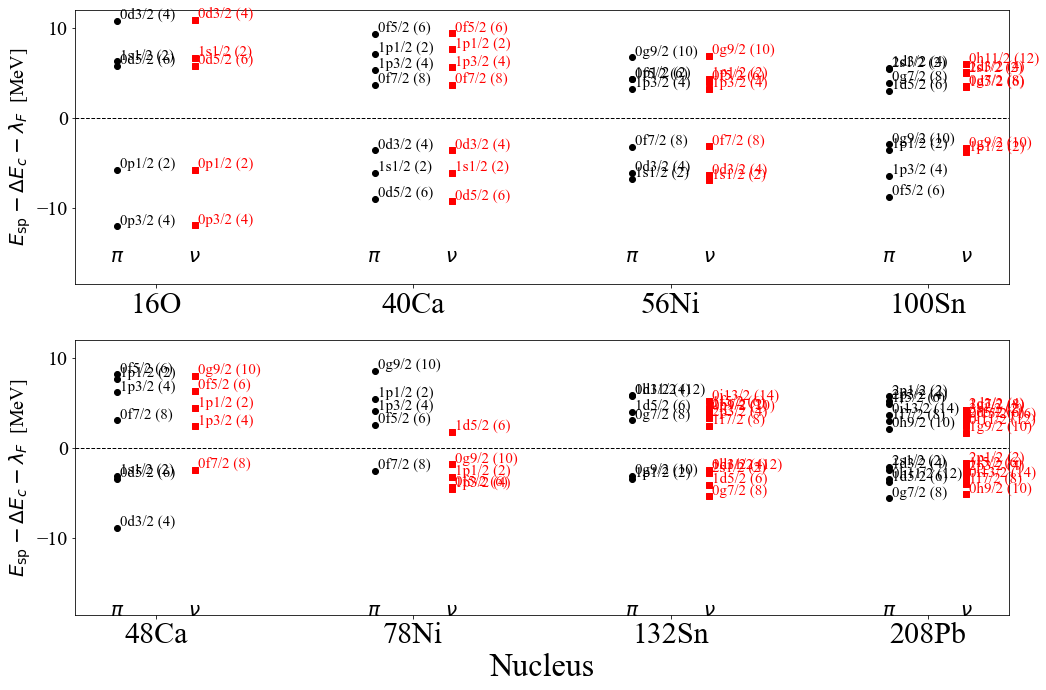

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
def degeneracy(orb):
    """
    Extract j from an orbital string like '0d5/2' or '1f7/2'
    returns (2j+1) as integer
    """
    import re
    # find the j part (digit/digit)
    m = re.search(r"(\d+)/(\d+)", orb)
    if m:
        num = int(m.group(1))
        den = int(m.group(2))
        j = num / den
        return int(2*j + 1)
    else:
        return None
# ================================================================
# 1. LOAD  CSV
# ================================================================
df = pd.read_csv("figure2_SPE_values.csv")
df["value"] = df["value"].astype(float)

# Define panel nucleus ordering (same as Grawe Fig. 2)
panel_A = ["16O", "40Ca", "56Ni", "100Sn"]
panel_B = ["48Ca", "78Ni", "132Sn", "208Pb"]

# ================================================================
# 2. GENERIC PLOT ROUTINE FOR A PANEL
# ================================================================
def plot_panel(ax, nuclei,normalize=True):
    """
    ax      : matplotlib axis
    nuclei  : list of nucleus names in x-order
    """

    # Horizontal positions: one slot per nucleus
    x_pos = {nuc: i for i, nuc in enumerate(nuclei)}
    
    
    if (normalize):
        # Draw Fermi line (already normalized to 0 in Grawe plot)
        ax.axhline(0, linestyle="--", color="black", linewidth=1)
    # Basic axis labels
    ax.set_xticks([x_pos[n] for n in nuclei])
    ax.set_xticklabels(nuclei, fontsize=30)
    if (normalize):
        ax.set_ylabel(r"$E_{\rm sp} - \Delta E_c - \lambda_F$  [MeV]")
    else:
        ax.set_ylabel(r"$E_{\rm sp}$")

    # Small offset to separate π and ν points
    dx = 0.15

    # Loop over each nucleus and plot levels
    for nuc in nuclei:
        Z = elements[nuc[len(str(getA(nuc))):].lower()]
        N = getA(nuc)-Z
        sub = df[df["nucleus"] == nuc]

        # protons
        p = sub[sub["particle"] == "proton"]
        
        
        xp = [x_pos[nuc] - dx] * len(p)
        midgap_proton = (p[p["gap_edge"]==2]["value"].iloc[0]+p[p["gap_edge"]==1]["value"].iloc[0])/2.
        if (not normalize):
            ax.annotate(f"{Z}", (x_pos[nuc]-dx, midgap_proton), xytext=(3, 2),
                        textcoords="offset points", fontsize=30,color='r')
            midgap_proton= 0
        ax.scatter(xp, p["value"]-midgap_proton, marker="o", color="black")

        # neutrons
        n = sub[sub["particle"] == "neutron"]
        
        
        xn = [x_pos[nuc] + dx] * len(n)
        midgap_neutron = (n[n["gap_edge"]==2]["value"].iloc[0]+n[n["gap_edge"]==1]["value"].iloc[0])/2.
        if (not normalize):
            ax.annotate(f"{N}", (x_pos[nuc]+dx, midgap_neutron), xytext=(3, 2),
                        textcoords="offset points", fontsize=30,color='r')
            midgap_neutron= 0
        ax.scatter(xn, n["value"]-midgap_neutron, marker="s", color="r")

        # Annotate orbitals
        for xv, yv, orb in zip(xp, p["value"]-midgap_proton, p["orbital"]):
            deg = degeneracy(orb)
            label = f"{orb} ({deg})"
            ax.annotate(label, (xv, yv), xytext=(3, 2),
                        textcoords="offset points", fontsize=15)
        for xv, yv, orb in zip(xn, n["value"]-midgap_neutron, n["orbital"]):
            deg = degeneracy(orb)
            label = f"{orb} ({deg})"
            ax.annotate(label, (xv, yv), xytext=(3, 2),
                        textcoords="offset points", fontsize=15,color='r')

        # Add π and ν labels below x-axis
        ymin, ymax = ax.get_ylim()
        ytext = ymin - 0.05*(ymax - ymin)
        ax.text(x_pos[nuc] - dx, ytext, r"$\pi$",
                ha="center", va="top", fontsize=20)
        ax.text(x_pos[nuc] + dx, ytext, r"$\nu$",
                ha="center", va="top", fontsize=20)

    # Expand bottom margin to fit the π/ν labels
    ymin, ymax = ax.get_ylim()
    ax.set_ylim(ymin - 0.1*(ymax - ymin), ymax)

# ================================================================
# 3. MAKE FIGURE WITH TWO PANELS
# ================================================================
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharey=True)

# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10), sharey=True)

plot_panel(ax1, panel_A)
plot_panel(ax2, panel_B)

ax2.set_xlabel("Nucleus", fontsize=32)

plt.tight_layout()

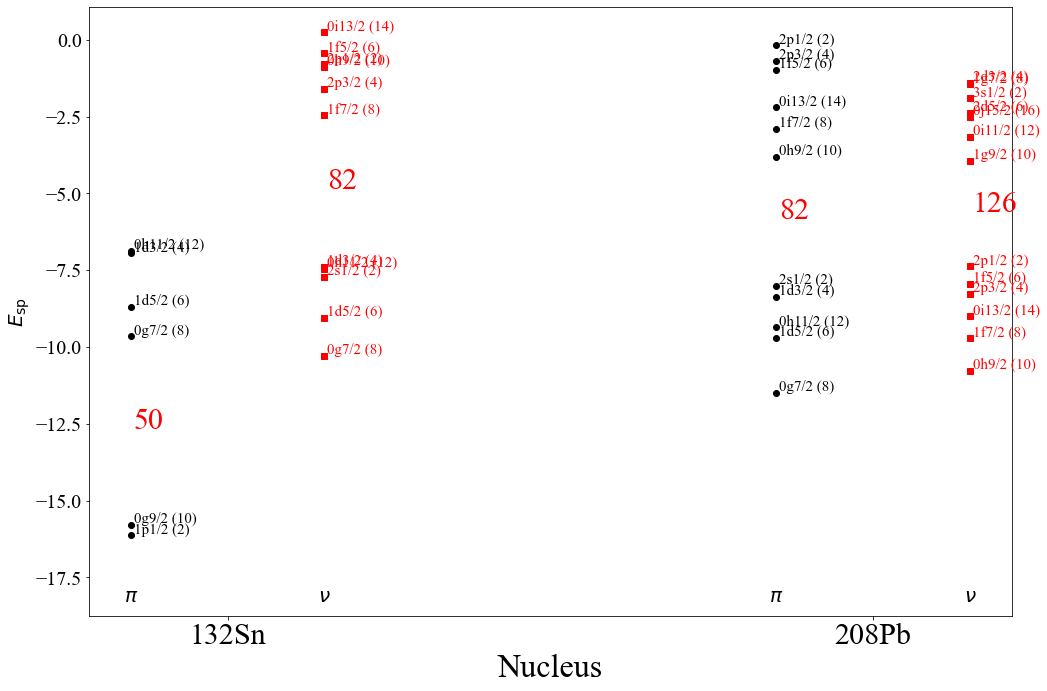

In [62]:
fig, ax = plt.subplots(figsize=(15, 10))

# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10), sharey=True)

panel_A = ["132Sn", "208Pb"]
plot_panel(ax, panel_A,normalize=False)

ax.set_xlabel("Nucleus", fontsize=32)

plt.tight_layout()

In [141]:
import numpy as np  # add this at the top of your file

def place_label_nonoverlap_horizontal(ax, x, y, text,
                                color='black', fontsize=15,
                                dx=0.05):
    """
    Places label near (x, y) but shifts ONLY to the LEFT to avoid overlap.
    dx = shift step size (positive; code will move left).
    """

    # storage for used label positions
    if not hasattr(ax, "_used_label_positions_left"):
        ax._used_label_positions_left = []   # list of (x, y)

    x_try = x

    for attempt in range(200):
        too_close = False

        for (x_used, y_used) in ax._used_label_positions_left:
            # same y region?
            if abs(y_used - y) < 0.10:
                # horizontal collision threshold
                if abs(x_try - x_used) < dx:
                    too_close = True
                    break

        if not too_close:
            break

        # shift LEFT only
        x_try -= dx

    # record this label's final position
    ax._used_label_positions_left.append((x_try, y))

    # place annotation
    ax.annotate(text, (x_try, y), xytext=(3, 0),
                textcoords="offset points",
                fontsize=fontsize, color=color,
                va="center")


def plot_panel(ax, nuclei, normalize=True,dxx=0.05):
    """
    ax      : matplotlib axis
    nuclei  : list of nucleus names in x-order
    """

    # Horizontal positions: one slot per nucleus
    x_pos = {nuc: i for i, nuc in enumerate(nuclei)}
    
    if normalize:
        # Draw Fermi line (already normalized to 0 in Grawe plot)
        ax.axhline(0, linestyle="--", color="black", linewidth=1)
    # Basic axis labels
    ax.set_xticks([x_pos[n] for n in nuclei])
    ax.set_xticklabels(nuclei, fontsize=30)
    if normalize:
        ax.set_ylabel(r"$E_{\rm sp} - \Delta E_c - \lambda_F$  [MeV]")
    else:
        ax.set_ylabel(r"$E_{\rm sp}$")

    # Small offset to separate π and ν "columns"
    dx = 0.15

    # Loop over each nucleus and plot levels
    for nuc in nuclei:
        Z = elements[nuc[len(str(getA(nuc))):].lower()]
        N = getA(nuc) - Z
        sub = df[df["nucleus"] == nuc]

        # ---------------- PROTONS ----------------
        p = sub[sub["particle"] == "proton"]
        xp = [x_pos[nuc] - dx] * len(p)

        midgap_proton = (p[p["gap_edge"] == 2]["value"].iloc[0]
                         + p[p["gap_edge"] == 1]["value"].iloc[0]) / 2.0
        if not normalize:
            ax.annotate(f"{Z}", (x_pos[nuc] - dx, midgap_proton), xytext=(3, 2),
                        textcoords="offset points", fontsize=30, color='r')
            midgap_proton = 0

        # Draw horizontal line + circles for each proton level
        for xv, yv, orb in zip(xp, p["value"] - midgap_proton, p["orbital"]):
            deg = degeneracy(orb)  # 2j+1
            # short horizontal line centered at xv
            half_width = 0.12  # tweak to taste
            x_left = xv - half_width
            x_right = xv + half_width
            ax.hlines(yv, x_left, x_right, colors="black", linewidth=1)

            # positions of deg circles along the line
            if deg is not None and deg > 0:
                xs = np.linspace(x_left, x_right, deg)
                ax.plot(xs, [yv]*deg, linestyle="None",
                        marker="o", markersize=4,
                        markerfacecolor="none", markeredgecolor="black")

            # label with orbital (you can add (deg) if you like)
            label = f"{orb} ({deg})"
            place_label_nonoverlap_horizontal(ax, x_right, yv, label, color='black', fontsize=15,dx=dxx)
#             ax.annotate(label, (x_right, yv), xytext=(3, 0),
#                         textcoords="offset points", fontsize=15,
#                         va="center")

        # ---------------- NEUTRONS ----------------
        n = sub[sub["particle"] == "neutron"]
        xn = [x_pos[nuc] + dx] * len(n)

        midgap_neutron = (n[n["gap_edge"] == 2]["value"].iloc[0]
                          + n[n["gap_edge"] == 1]["value"].iloc[0]) / 2.0
        if not normalize:
            ax.annotate(f"{N}", (x_pos[nuc] + dx, midgap_neutron), xytext=(3, 2),
                        textcoords="offset points", fontsize=30, color='r')
            midgap_neutron = 0

        # Draw horizontal line + circles for each neutron level
        for xv, yv, orb in zip(xn, n["value"] - midgap_neutron, n["orbital"]):
            deg = degeneracy(orb)
            half_width = 0.12
            x_left = xv - half_width
            x_right = xv + half_width
            ax.hlines(yv, x_left, x_right, colors="red", linewidth=1)

            if deg is not None and deg > 0:
                xs = np.linspace(x_left, x_right, deg)
                ax.plot(xs, [yv]*deg, linestyle="None",
                        marker="o", markersize=4,
                        markerfacecolor="none", markeredgecolor="red")

            label = f"{orb} ({deg})"
            place_label_nonoverlap_horizontal(ax, x_right, yv, label, color='r', fontsize=15,dx=dxx)
#             ax.annotate(label, (x_right, yv), xytext=(3, 0),
#                         textcoords="offset points", fontsize=15,
#                         va="center", color='r')

        # Add π and ν labels below x-axis
        ymin, ymax = ax.get_ylim()
        ytext = ymin - 0.05*(ymax - ymin)
        ax.text(x_pos[nuc] - dx, ytext, r"$\pi$",
                ha="center", va="top", fontsize=20)
        ax.text(x_pos[nuc] + dx, ytext, r"$\nu$",
                ha="center", va="top", fontsize=20)

    # Expand bottom margin to fit the π/ν labels
    ymin, ymax = ax.get_ylim()
    ax.set_ylim(ymin - 0.1*(ymax - ymin), ymax)


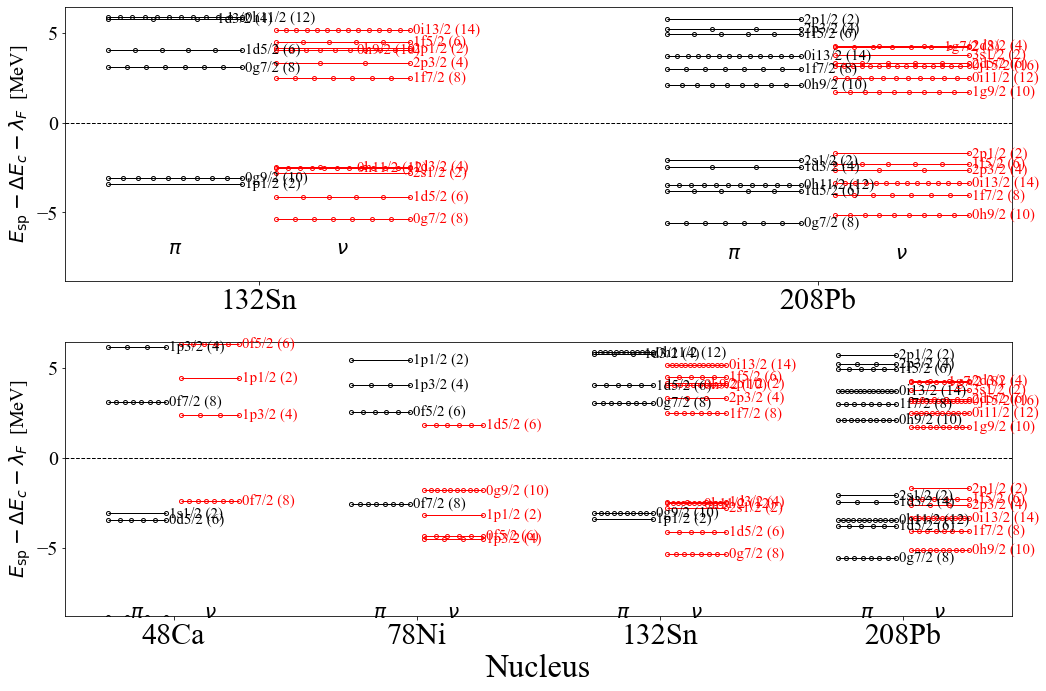

In [142]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharey=True)

plot_panel(ax1, panel_A)
plot_panel(ax2, panel_B)

ax2.set_xlabel("Nucleus", fontsize=32)
plt.tight_layout()
plt.show()

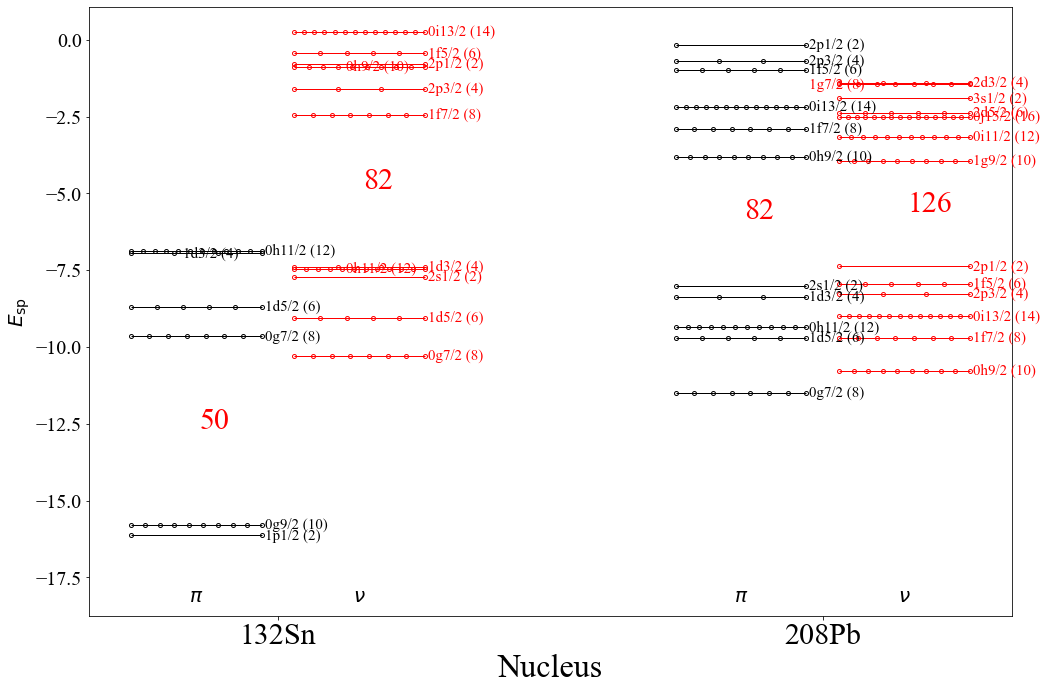

In [149]:
fig, ax = plt.subplots(figsize=(15, 10))

# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10), sharey=True)

panel_A = ["132Sn", "208Pb"]
plot_panel(ax, panel_A,normalize=False,dxx=0.15)

ax.set_xlabel("Nucleus", fontsize=32)

plt.tight_layout()

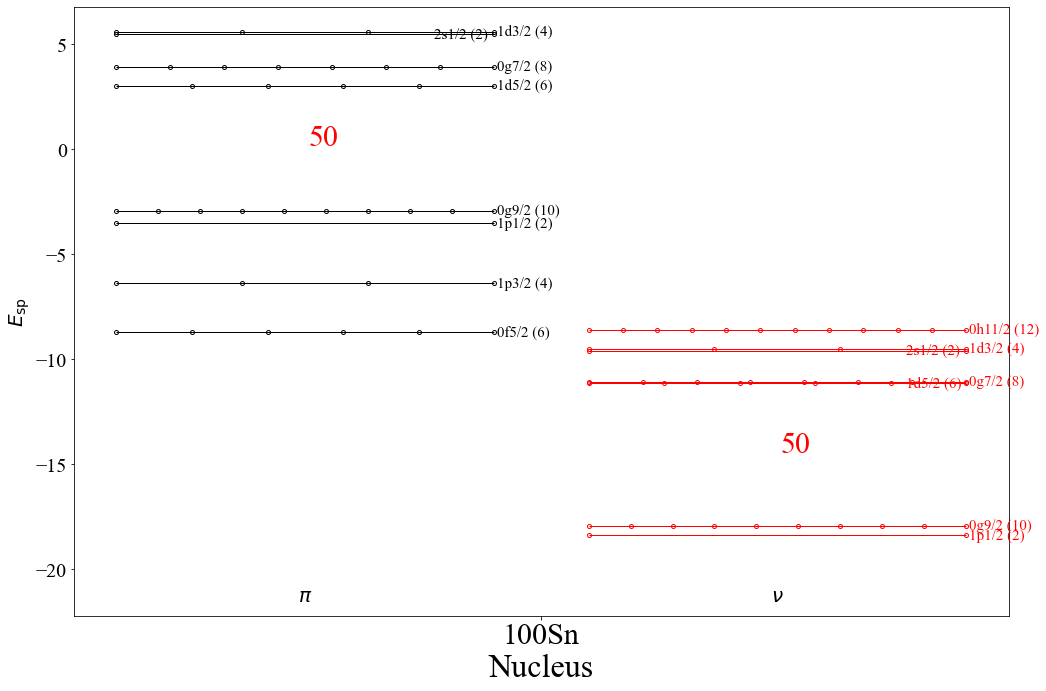

In [150]:
fig, ax = plt.subplots(figsize=(15, 10))

# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10), sharey=True)

panel_A = ["100Sn"]
plot_panel(ax, panel_A,normalize=False,dxx=0.04)
ax.set_xlabel("Nucleus", fontsize=32)

plt.tight_layout()

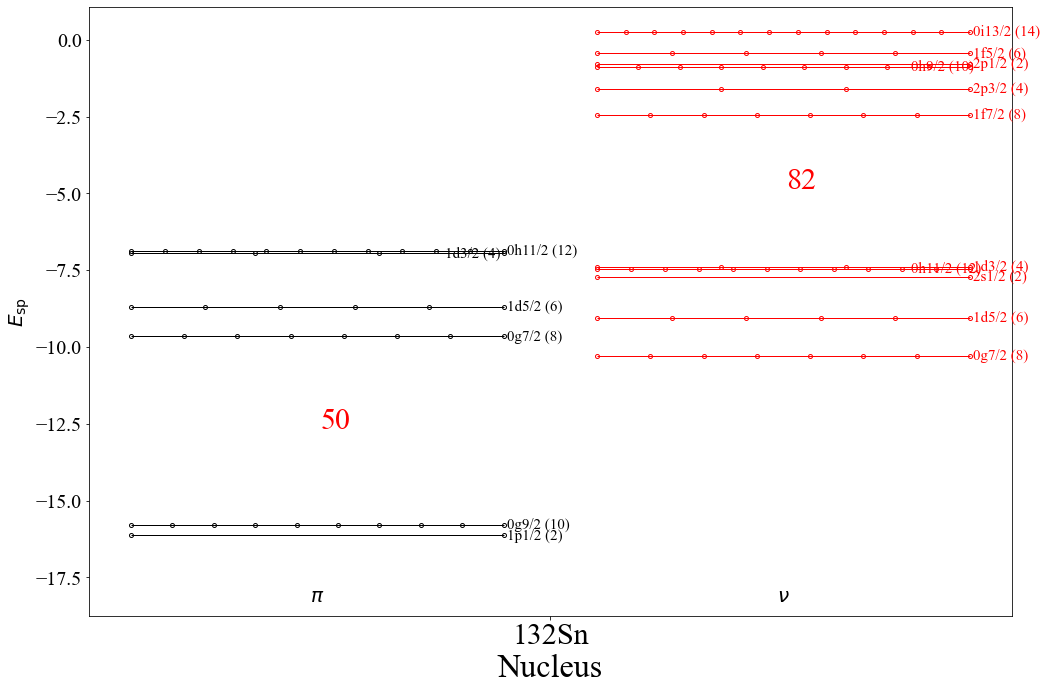

In [151]:
fig, ax = plt.subplots(figsize=(15, 10))

# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10), sharey=True)

panel_A = ["132Sn"]
plot_panel(ax, panel_A,normalize=False,dxx=0.04)
ax.set_xlabel("Nucleus", fontsize=32)

plt.tight_layout()

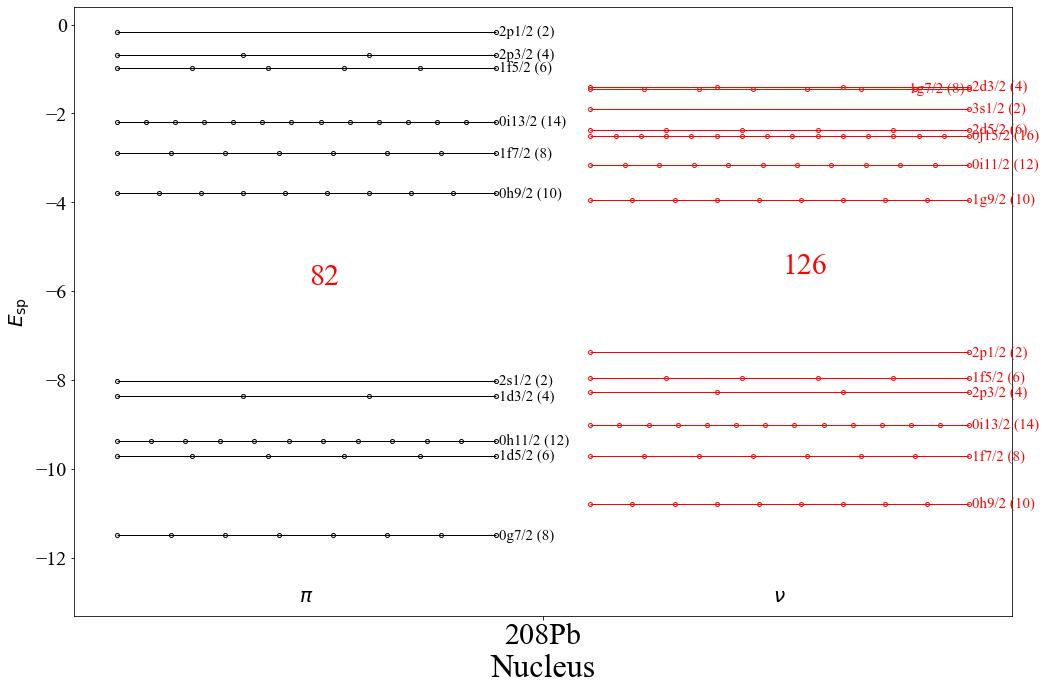

In [152]:
fig, ax = plt.subplots(figsize=(15, 10))

# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10), sharey=True)

panel_A = ["208Pb"]
plot_panel(ax, panel_A,normalize=False,dxx=0.04)
ax.set_xlabel("Nucleus", fontsize=32)

plt.tight_layout()